In [1]:
##### Let's import the libraries we're going to use and define Hermite polynomial function for He(x)'s
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy.stats import truncnorm

np.random.seed(42)  # You can choose any integer value for the seed

#Let's create a function for building Hermite polynomial:
def hermite_polynomial(x, degree):
    if degree == 0:
        He=np.ones_like(x)

    else:
        He = [np.ones_like(x), x]
        for n in range(2, degree + 1):
            He_n = x * He[n - 1] - (n - 1) * He[n - 2]
            He.append(He_n)
        return np.array(He).T  # Transpose the result to have each row correspond to a single input vector
#Let's check it.... we are expecting to get m x p matrix where p is a degree (3+1=4)
a=np.array([1,2,3,4,5])*0.1
hermite_polynomial(a,5)

array([[ 1.     ,  0.1    , -0.99   , -0.299  ,  2.9401 ,  1.49001],
       [ 1.     ,  0.2    , -0.96   , -0.592  ,  2.7616 ,  2.92032],
       [ 1.     ,  0.3    , -0.91   , -0.873  ,  2.4681 ,  4.23243],
       [ 1.     ,  0.4    , -0.84   , -1.136  ,  2.0656 ,  5.37024],
       [ 1.     ,  0.5    , -0.75   , -1.375  ,  1.5625 ,  6.28125]])

In [2]:
#Let's now populate our parameters:
# Parameters for the lognormal distribution
def nrv(nrv_min=470000, nrv_mode=500000, nrv_max=515000, num_samples=10000):
    
    # Calculate mean and standard deviation of the lognormal distribution
    mean_nrv=np.log(nrv_mode**2 / np.sqrt(nrv_min * nrv_max))
    sigma_nrv=np.sqrt(np.log(nrv_max / nrv_min) / (2.706 - np.log(nrv_mode / np.sqrt(nrv_min * nrv_max))))
    
    # Generate samples from the lognormal distribution
    samples_nrv = np.random.lognormal(mean=mean_nrv, sigma=sigma_nrv, size=num_samples)

    # Take the natural logarithm of the samples to get samples of ln(NRV)
    samples_ln_nrv = np.log(samples_nrv)

    # Standardize ln(NRV) samples to obtain z-scores
    mean_ln_nrv=np.mean(samples_ln_nrv)
    sd_ln_nrv=np.std(samples_ln_nrv)
    z_scores_ln_nrv = (samples_ln_nrv - mean_ln_nrv)/sd_ln_nrv

    return mean_ln_nrv, sd_ln_nrv, z_scores_ln_nrv, samples_ln_nrv, samples_nrv

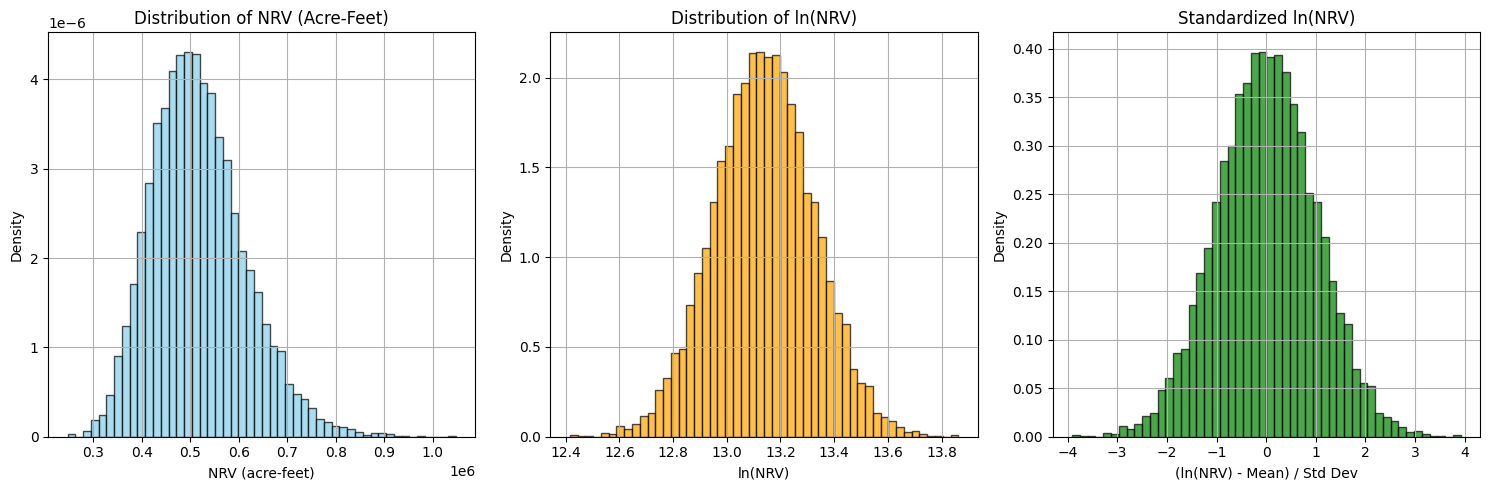

Mean of the log-normal distribution:               13.138
Standard deviation of the log-normal distribution:  0.185
Mean of the NRV:                               516713.371
Standard deviation of NRV:                      96457.746


In [3]:
mean_ln_nrv, sd_ln_nrv, z_scores_ln_nrv, samples_ln_nrv, samples_nrv=nrv()
# Plot histograms of NRV in acre-feet, ln(NRV), and standardized ln(NRV)
plt.figure(figsize=(15, 5))

# Plot histogram of NRV in acre-feet
plt.subplot(1, 3, 1)
plt.hist(samples_nrv, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of NRV (Acre-Feet)')
plt.xlabel('NRV (acre-feet)')
plt.ylabel('Density')
plt.grid(True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Plot histogram of ln(NRV)
plt.subplot(1, 3, 2)
plt.hist(samples_ln_nrv, bins=50, density=True, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of ln(NRV)')
plt.xlabel('ln(NRV)')
plt.ylabel('Density')
plt.grid(True)

# Plot histogram of standardized ln(NRV)
plt.subplot(1, 3, 3)
plt.hist(z_scores_ln_nrv, bins=50, density=True, color='green', edgecolor='black', alpha=0.7)
plt.title('Standardized ln(NRV)')
plt.xlabel('(ln(NRV) - Mean) / Std Dev')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()
  
print(f"Mean of the log-normal distribution:              {mean_ln_nrv: .3f}\nStandard deviation of the log-normal distribution: {sd_ln_nrv: .3f}")
print(f"Mean of the NRV:                              {np.mean(samples_nrv): .3f}\nStandard deviation of NRV:                     {np.std(samples_nrv): .3f}")

In [4]:
#Sampling... In order to train our model we need samples... This function is for sampling for proper size
def sample(z_scores, lower_bound = -3, upper_bound = 3, sample_size = 1000):
    samples = []
    while len(samples) < sample_size:
        # Sample from the population
        sample = np.random.choice(z_scores)
        # Check if the sample falls within the specified bounds
        if lower_bound <= sample <= upper_bound:
            samples.append(sample)

    # Convert the list of samples to a NumPy array
    samples = np.array(samples)
    
    return samples

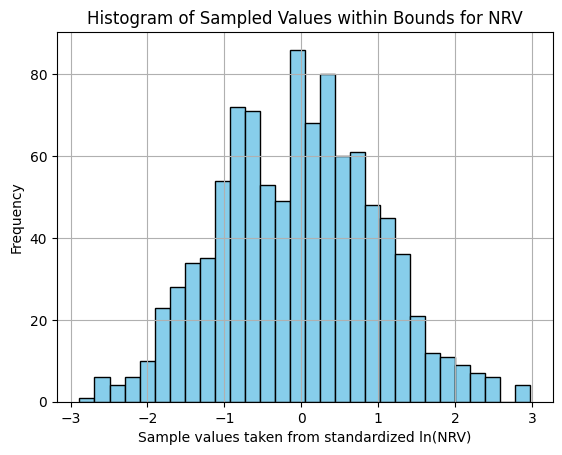

In [5]:
#selected_nrv is the Gaussian Distribution...
selected_nrv=sample(z_scores=z_scores_ln_nrv)

#Plot histogram of the samples to visualize their distribution
plt.hist(selected_nrv, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sample values taken from standardized ln(NRV)')
plt.ylabel('Frequency')
plt.title('Histogram of Sampled Values within Bounds for NRV')
plt.grid(True)
plt.show()

In [6]:
#Training the model
def train(samples, sd_ln, mean_ln, samples_ln, degree=6):
    x_ln=samples * sd_ln + mean_ln
    y=np.exp(x_ln)
    X=hermite_polynomial(samples, degree)
    A=np.dot(np.linalg.pinv(np.dot(X.T,X)), np.dot(X.T,y))
    
    mean_sample=np.mean(np.exp(x_ln))
    sd_sample=np.std(np.exp(x_ln))
        
    h=np.dot(X,A)
    y=np.exp(x_ln)
    if (1/len(y))*np.sum(y)>1:
                  squared_err=np.sum(np.square(h-y))
    else: squared_err=np.sum(np.abs(h-y))
    
    #Calculating mean and sd of modelled data:
    mean_model=np.mean(h)
    sd_model=np.std(h)
    
    mu=A[0]
    var=0
                        
    for i in range(1, len(A)):
        var+=A[i]**2
                            
    return x_ln, mean_sample, sd_sample, mean_model, sd_model, squared_err, h, y, A, mu, var

Mean of Sample variables:              512824.823
Standard Deviation of Sample variables: 98093.693
Squared error for Actual vs Modelled based on Samples is 0.07
Mean of modelled data:                 512824.82
Standard deviation of modelled data:    98093.69
Mean from A:                           516711.65
std from A:                             96000.98


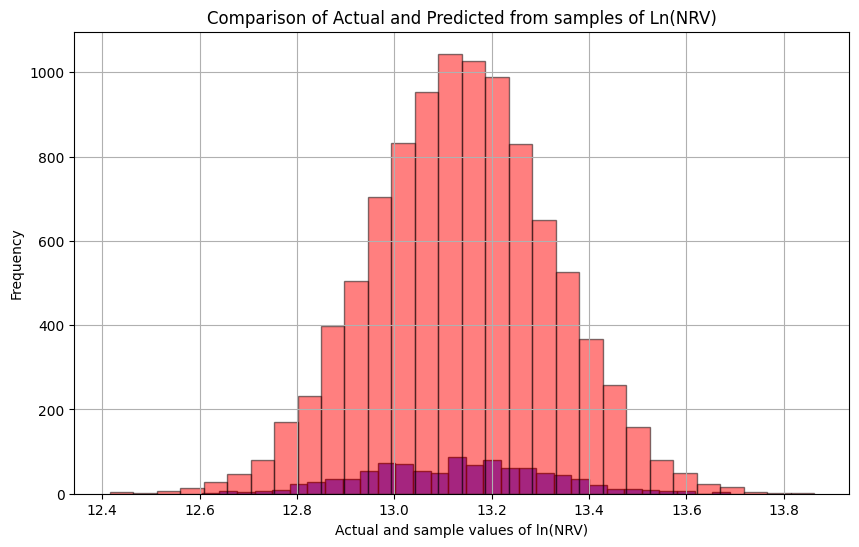

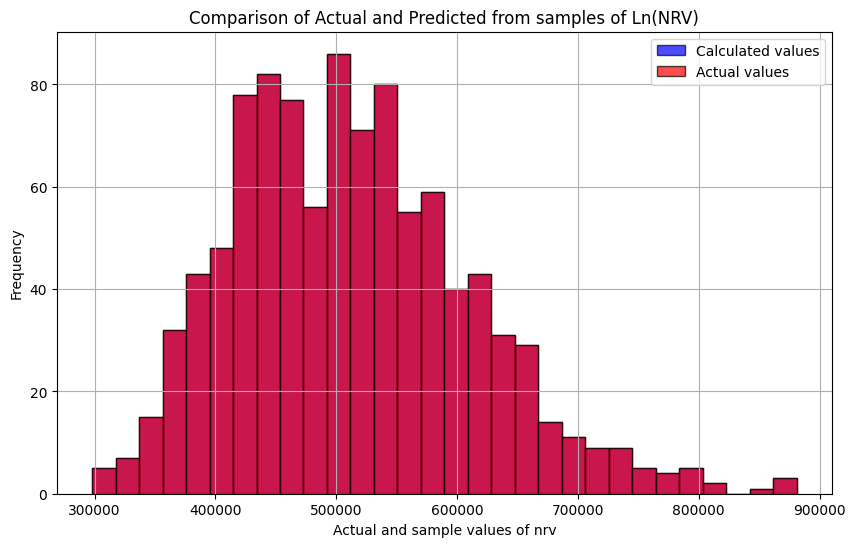

In [7]:
x_ln_nrv, mean_sample_nrv, sd_sample_nrv, mean_model_nrv, sd_model_nrv, squared_err_nrv, h_nrv,nrv, A_nrv, mu_nrv, var_nrv=train(samples=selected_nrv, sd_ln=sd_ln_nrv, mean_ln=mean_ln_nrv, samples_ln=samples_ln_nrv)

print(f"Mean of Sample variables:              {mean_sample_nrv:.3f}\nStandard Deviation of Sample variables: {sd_sample_nrv:.3f}")
print(f"Squared error for Actual vs Modelled based on Samples is {squared_err_nrv:.2f}")
print(f"Mean of modelled data:                 {mean_model_nrv:.2f}\nStandard deviation of modelled data:    {sd_model_nrv:.2f}")
print(f"Mean from A:                           {mu_nrv:.2f}")
print(f"std from A:                             {np.sqrt(var_nrv):.2f}")
  
plt.figure(figsize=(10, 6))
plt.hist(x_ln_nrv, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.hist(samples_ln_nrv, bins=30, color='red', edgecolor='black', alpha=0.5)
plt.xlabel('Actual and sample values of ln(NRV)')
plt.ylabel('Frequency')
plt.title('Comparison of Actual and Predicted from samples of Ln(NRV)')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(h_nrv, bins=30, color='blue', edgecolor='black', alpha=0.7, label='Calculated values')
plt.hist(nrv, bins=30, color='red', edgecolor='black', alpha=0.7, label='Actual values')
plt.xlabel('Actual and sample values of nrv')
plt.ylabel('Frequency')
plt.title('Comparison of Actual and Predicted from samples of Ln(NRV)')
plt.grid(True)
plt.legend(['Calculated values', 'Actual values'])
plt.show()

In [ ]:
SSE_nrv_pop=[]
SSE_nrv_sample=[]
degrees=range(4,10)
mus_nrv=[]
vars_nrv=[]

for i in degrees:
    _, _, _, _, _, squared_err_nrv_sample, _, _, A_nrv, mu_nrv, var_nrv =train(samples=selected_nrv, sd_ln=sd_ln_nrv, mean_ln=mean_ln_nrv, samples_ln=samples_ln_nrv, degree=i)
    SSE_nrv_sample.append(squared_err_nrv_sample)
    mus_nrv.append(mu_nrv)
    vars_nrv.append(var_nrv)
    X=hermite_polynomial(z_scores_ln_nrv,i)
    h=np.dot(X, A_nrv)
    err_nrv=np.sum(np.square(h-samples_nrv))
    SSE_nrv_pop.append(err_nrv)
    
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Degrees')
ax1.set_ylabel('Sample', color=color)
ax1.plot(degrees, SSE_nrv_sample, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Population', color=color)
ax2.plot(degrees, SSE_nrv_pop, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the x-axis tick step to 1
plt.xticks(ticks=np.arange(min(degrees), max(degrees)+1, 1))

# Fixed value
mean_nrv_ = np.mean(samples_nrv)
sd_nrv_=np.std(samples_nrv)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, mus_nrv, marker='o', linestyle='', label='Mean Values from A')
plt.axhline(y=mean_nrv_, color='r', linestyle='--', label='Mean of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('Mean values from A\'s for each degree')
plt.title('Comparison of Mean of the population vs Mean from A coefficient')
plt.xticks(range(min(degrees), max(degrees)+1))
plt.legend()

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, np.sqrt(vars_nrv), marker='o', linestyle='', label='STD Values from A')
plt.axhline(y=sd_nrv_, color='r', linestyle='--', label='STD of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('STD values from A\'s for each degree')
plt.xticks(range(min(degrees), max(degrees)+1))
plt.title('Comparison of Mean of the population vs Mean from A coefficient')
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
#Here we'll use the degree of 5 for NRV. sample_size will be 1500, 2500, 3500, 4500, 6000, 7500
population_size=10000
sample_sizes=np.dot(np.array([0.15, 0.25, 0.35, 0.45, 0.60, 0.75]), population_size)
SSE_nrv_pop_ss=[]
SSE_nrv_sample_ss=[]
mus_nrv_ss=[]
vars_nrv_ss=[]

#Sampling... In order to train our model we need samples... This function is for sampling for proper size
for i in sample_sizes:
    selected_nrv_ss=sample(z_scores=z_scores_ln_nrv, sample_size=i)
    _, _, _, _, _, squared_err_nrv_sample_ss, _, _, A_nrv_ss, mu_nrv_ss, var_nrv_ss =train(samples=selected_nrv_ss, sd_ln=sd_ln_nrv, mean_ln=mean_ln_nrv, samples_ln=samples_ln_nrv, degree=5)
    SSE_nrv_sample_ss.append(squared_err_nrv_sample_ss)
    mus_nrv_ss.append(mu_nrv_ss)
    vars_nrv_ss.append(var_nrv_ss)
    
    X=hermite_polynomial(z_scores_ln_nrv, degree=5)
    h=np.dot(X, A_nrv_ss)
    err_nrv_ss=np.sum(np.square(h-samples_nrv))
    SSE_nrv_pop_ss.append(err_nrv_ss)
    
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Sample_Sizes')
ax1.set_ylabel('Sample', color=color)
ax1.plot(sample_sizes, SSE_nrv_sample_ss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Population', color=color)
ax2.plot(sample_sizes, SSE_nrv_pop_ss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, mus_nrv_ss, marker='o', linestyle='', label='Mean Values from A')
plt.axhline(y=mean_nrv_, color='r', linestyle='--', label='Mean of Population')

# Add labels and title
plt.xlabel('Sample Size')
plt.ylabel('Mean values from A\'s for each sample size')
plt.title('Comparison of Mean of the population vs Mean from A coefficient for different sample Sizes')
plt.legend()

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, np.sqrt(vars_nrv_ss), marker='o', linestyle='', label='STD Values from A')
plt.axhline(y=sd_nrv_, color='r', linestyle='--', label='STD of Population')

# Add labels and title
plt.xlabel('Sample Sizes')
plt.ylabel('STD values from A\'s for each sample size')
plt.title('Comparison of Mean of the population vs Mean from A coefficient for different sample sizes')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [8]:
#Let's now populate our parameters:
# Parameters for the lognormal distribution
def phi(phi_min=0.15, phi_mode=0.25, phi_max=0.32, num_samples=10000):
    
    # Calculate mean and standard deviation of the lognormal distribution
    mean_phi=np.log(phi_mode**2 / np.sqrt(phi_min * phi_max))
    sigma_phi=np.sqrt(np.log(phi_max / phi_min) / (2.706 - np.log(phi_mode / np.sqrt(phi_min * phi_max))))
    
    # Generate samples from the lognormal distribution
    lognorm_phi=lognorm(s=sigma_phi, scale=np.exp(mean_phi))    
    
    samples_phi=np.array([])
    while len(samples_phi)<num_samples:
        samples_phi = lognorm_phi.rvs(size=num_samples)
        samples_phi = samples_phi[(samples_phi >= phi_min) &(samples_phi <= 0.5)]
        samples_phi = np.append(samples_phi, lognorm_phi.rvs(size=num_samples - len(samples_phi)))
    
    # Take the natural logarithm of the samples to get samples of ln(phi)
    samples_ln_phi = np.log(samples_phi)

    # Standardize ln(phi) samples to obtain z-scores
    mean_ln_phi=np.mean(samples_ln_phi)
    sd_ln_phi=np.std(samples_ln_phi)
    z_scores_ln_phi = (samples_ln_phi - mean_ln_phi)/sd_ln_phi

    return mean_ln_phi, sd_ln_phi, z_scores_ln_phi, samples_ln_phi, samples_phi

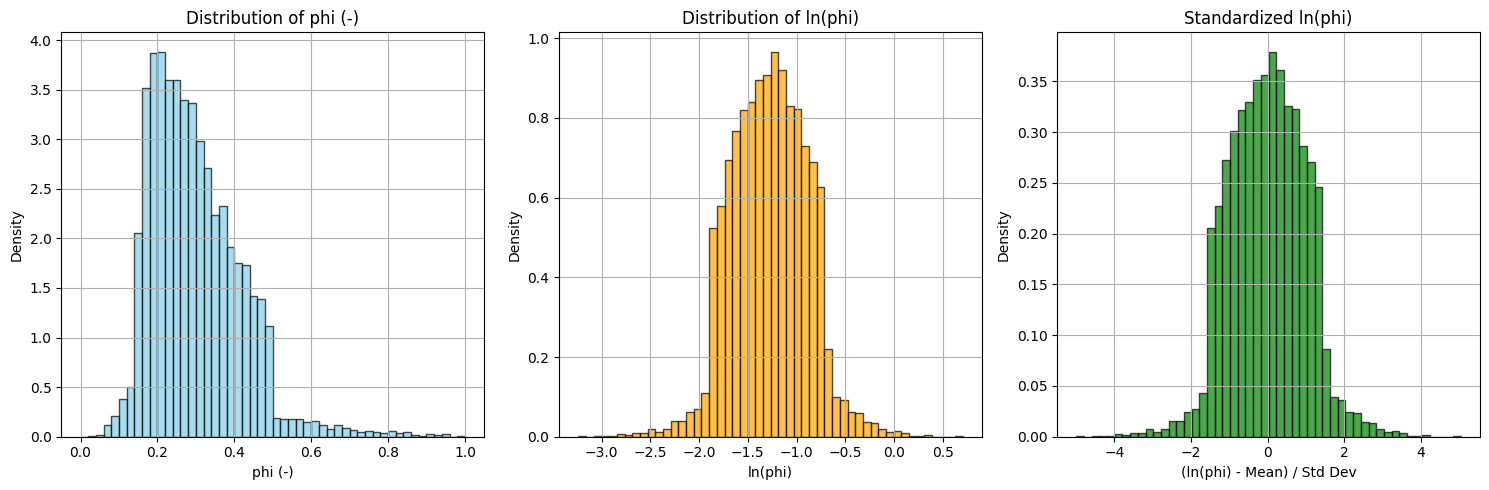

Mean of the log-normal distribution:              -1.277
Standard deviation of the log-normal distribution: 0.392
Mean of the phi:                                   0.301
Standard deviation of phi:                         0.127


In [9]:
mean_ln_phi, sd_ln_phi, z_scores_ln_phi, samples_ln_phi, samples_phi=phi()
# Plot histograms of phi in fraction, ln(phi), and standardized ln(phi)
plt.figure(figsize=(15, 5))

# Plot histogram of phi in fraction
plt.subplot(1, 3, 1)
plt.hist(samples_phi, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7, range=(0,1))
plt.title('Distribution of phi (-)')
plt.xlabel('phi (-)')
plt.ylabel('Density')
plt.grid(True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Plot histogram of ln(phi)
plt.subplot(1, 3, 2)
plt.hist(samples_ln_phi, bins=50, density=True, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of ln(phi)')
plt.xlabel('ln(phi)')
plt.ylabel('Density')
plt.grid(True)

# Plot histogram of standardized ln(phi)
plt.subplot(1, 3, 3)
plt.hist(z_scores_ln_phi, bins=50, density=True, color='green', edgecolor='black', alpha=0.7)
plt.title('Standardized ln(phi)')
plt.xlabel('(ln(phi) - Mean) / Std Dev')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()
  
print(f"Mean of the log-normal distribution:              {mean_ln_phi: .3f}\nStandard deviation of the log-normal distribution:{sd_ln_phi: .3f}")
print(f"Mean of the phi:                                  {np.mean(samples_phi): .3f}\nStandard deviation of phi:                        {np.std(samples_phi): .3f}")

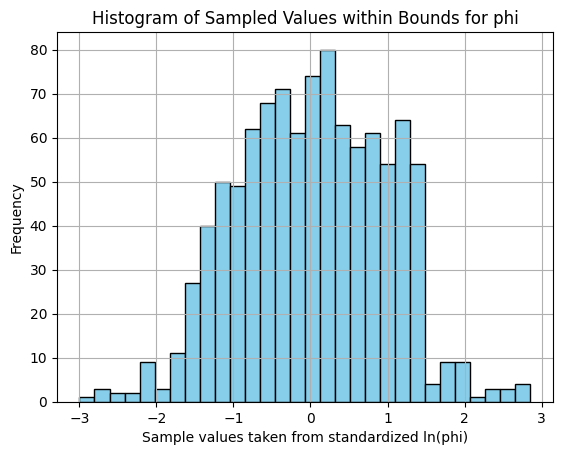

In [10]:
selected_phi=sample(z_scores=z_scores_ln_phi)

#Plot histogram of the samples to visualize their distribution
plt.hist(selected_phi, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sample values taken from standardized ln(phi)')
plt.ylabel('Frequency')
plt.title('Histogram of Sampled Values within Bounds for phi')
plt.grid(True)
plt.show()

Mean of Sample variables:              0.302
Standard Deviation of Sample variables: 0.116
Sum of Absolute error for Actual vs Modelled based on Samples is 542.55e-06
Mean of modelled data:                 0.30
Standard deviation of modelled data:    0.12
Mean from A:                           0.30
std from A:                             0.12


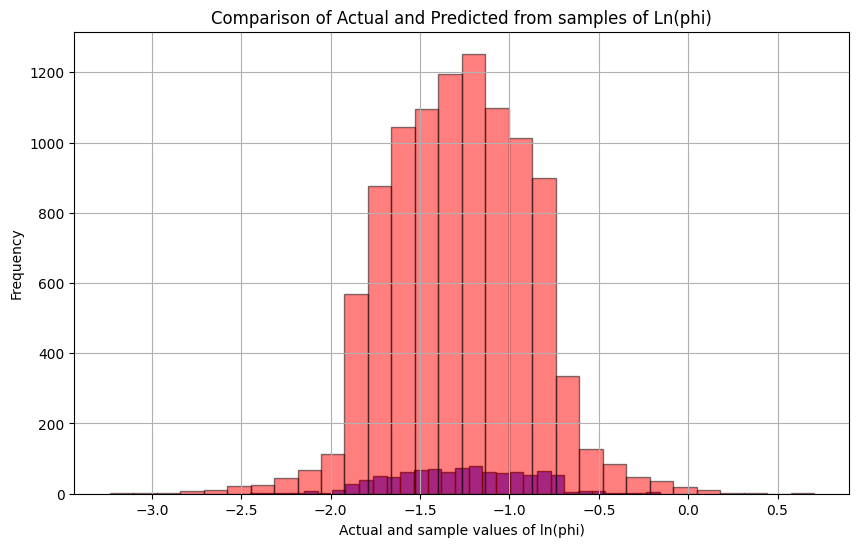

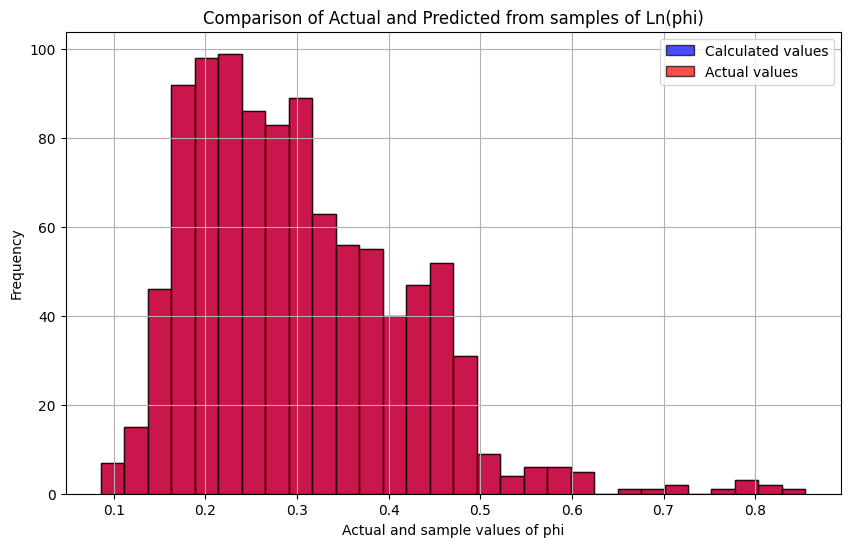

In [11]:
x_ln_phi, mean_sample_phi, sd_sample_phi, mean_model_phi, sd_model_phi, squared_err_phi, h_phi, phi, A_phi, mu_phi, var_phi=train(samples=selected_phi, sd_ln=sd_ln_phi, mean_ln=mean_ln_phi, samples_ln=samples_ln_phi)

print(f"Mean of Sample variables:              {mean_sample_phi:.3f}\nStandard Deviation of Sample variables: {sd_sample_phi:.3f}")
print(f"Sum of Absolute error for Actual vs Modelled based on Samples is {10**6*squared_err_phi:.2f}e-06")
print(f"Mean of modelled data:                 {mean_model_phi:.2f}\nStandard deviation of modelled data:    {sd_model_phi:.2f}")
print(f"Mean from A:                           {mu_phi:.2f}")
print(f"std from A:                             {np.sqrt(var_phi):.2f}")
  
plt.figure(figsize=(10, 6))
plt.hist(x_ln_phi, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.hist(samples_ln_phi, bins=30, color='red', edgecolor='black', alpha=0.5)
plt.xlabel('Actual and sample values of ln(phi)')
plt.ylabel('Frequency')
plt.title('Comparison of Actual and Predicted from samples of Ln(phi)')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(h_phi, bins=30, color='blue', edgecolor='black', alpha=0.7, label='Calculated values')
plt.hist(phi, bins=30, color='red', edgecolor='black', alpha=0.7, label='Actual values')
plt.xlabel('Actual and sample values of phi')
plt.ylabel('Frequency')
plt.title('Comparison of Actual and Predicted from samples of Ln(phi)')
plt.grid(True)
plt.legend(['Calculated values', 'Actual values'])
plt.show()

In [ ]:
SAE_phi_pop=[]
SAE_phi_sample=[]
degrees=range(4,8)
mus_phi=[]
vars_phi=[]

for i in degrees:
    _, _, _, _, _, squared_err_phi_sample, _, _, A_phi, mu_phi, var_phi =train(samples=selected_phi, sd_ln=sd_ln_phi, mean_ln=mean_ln_phi, samples_ln=samples_ln_phi, degree=i)
    SAE_phi_sample.append(squared_err_phi_sample)
    mus_phi.append(mu_phi)
    vars_phi.append(var_phi)
    
    X=hermite_polynomial(z_scores_ln_phi, i)
    h=np.dot(X, A_phi)
    err_phi=np.sum(np.square(h-samples_phi))
    SAE_phi_pop.append(err_phi)
    
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Degrees')
ax1.set_ylabel('Sample', color=color)
ax1.plot(degrees, SAE_phi_sample, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Population', color=color)
ax2.plot(degrees, SAE_phi_pop, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the x-axis tick step to 1
plt.xticks(ticks=np.arange(min(degrees), max(degrees)+1, 1))

# Fixed value
mean_phi_ = np.mean(samples_phi)
sd_phi_=np.std(samples_phi)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, mus_phi, marker='o', linestyle='', label='Mean Values from A')
plt.axhline(y=mean_phi_, color='r', linestyle='--', label='Mean of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('Mean values from A\'s for each degree')
plt.title('Comparison of Mean of the population vs Mean from A coefficient')
plt.legend()
plt.xticks(range(min(degrees), max(degrees)+1))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, np.sqrt(vars_phi), marker='o', linestyle='', label='STD Values from A')
plt.axhline(y=sd_phi_, color='r', linestyle='--', label='STD of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('STD values from A\'s for each degree')
plt.title('Comparison of STD of the population vs Mean from A coefficient')
plt.legend()
plt.xticks(range(min(degrees), max(degrees)+1))

plt.grid(True)
plt.show()

In [ ]:
#Here we'll use the degree of 5 for NRV. sample_size will be 1500, 2500, 3500, 4500, 6000, 7500
population_size=10000
sample_sizes=np.dot(np.array([0.15, 0.25, 0.35, 0.45, 0.60, 0.75]), population_size)
SSE_phi_pop_ss=[]
SSE_phi_sample_ss=[]
mus_phi_ss=[]
vars_phi_ss=[]

#Sampling... In order to train our model we need samples... This function is for sampling for proper size
for i in sample_sizes:
    selected_phi_ss=sample(z_scores=z_scores_ln_phi, sample_size=i)
    _, _, _, _, _, squared_err_phi_sample_ss, _, _, A_phi_ss, mu_phi_ss, var_phi_ss =train(samples=selected_phi_ss, sd_ln=sd_ln_phi, mean_ln=mean_ln_phi, samples_ln=samples_ln_phi, degree=5)
    SSE_phi_sample_ss.append(squared_err_phi_sample_ss)
    mus_phi_ss.append(mu_phi_ss)
    vars_phi_ss.append(var_phi_ss)
    
    X=hermite_polynomial(z_scores_ln_phi, 5)
    h=np.dot(X, A_phi_ss)
    err_phi_ss=np.sum(np.square(h-samples_phi))
    SSE_phi_pop_ss.append(err_phi_ss)
    
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Sample_Sizes')
ax1.set_ylabel('Sample', color=color)
ax1.plot(sample_sizes, SSE_phi_sample_ss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Population', color=color)
ax2.plot(sample_sizes, SSE_phi_pop_ss, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, mus_phi_ss, marker='o', linestyle='', label='Mean Values from A')
plt.axhline(y=mean_phi_, color='r', linestyle='--', label='Mean of Population')

# Add labels and title
plt.xlabel('Sample Size')
plt.ylabel('Mean values from A\'s for each sample size')
plt.title('Comparison of Mean of the population vs Mean from A coefficient for different sample Sizes')
plt.legend()

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, np.sqrt(vars_phi_ss), marker='o', linestyle='', label='STD Values from A')
plt.axhline(y=sd_phi_, color='r', linestyle='--', label='STD of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('STD values from A\'s for each sample size')
plt.title('Comparison of Mean of the population vs Mean from A coefficient for different sample sizes')
plt.legend()

In [12]:
#Let's now populate our parameters:
# Parameters for the lognormal distribution
def swc(swc_min=0.18, swc_mode=0.21, swc_max=0.28, num_samples=10000):
    
    # Calculate mean and standard deviation of the lognormal distribution
    mean_swc=np.log(swc_mode**2 / np.sqrt(swc_min * swc_max))
    sigma_swc=np.sqrt(np.log(swc_max / swc_min) / (2.706 - np.log(swc_mode / np.sqrt(swc_min * swc_max))))
    
    # Generate samples from the lognormal distribution
    samples_swc = np.random.lognormal(mean=mean_swc, sigma=sigma_swc, size=num_samples)

    # Take the natural logarithm of the samples to get samples of ln(swc)
    samples_ln_swc = np.log(samples_swc)

    # Standardize ln(Swc) samples to obtain z-scores
    mean_ln_swc=np.mean(samples_ln_swc)
    sd_ln_swc=np.std(samples_ln_swc)
    z_scores_ln_swc = (samples_ln_swc - mean_ln_swc)/sd_ln_swc

    return mean_ln_swc, sd_ln_swc, z_scores_ln_swc, samples_ln_swc, samples_swc

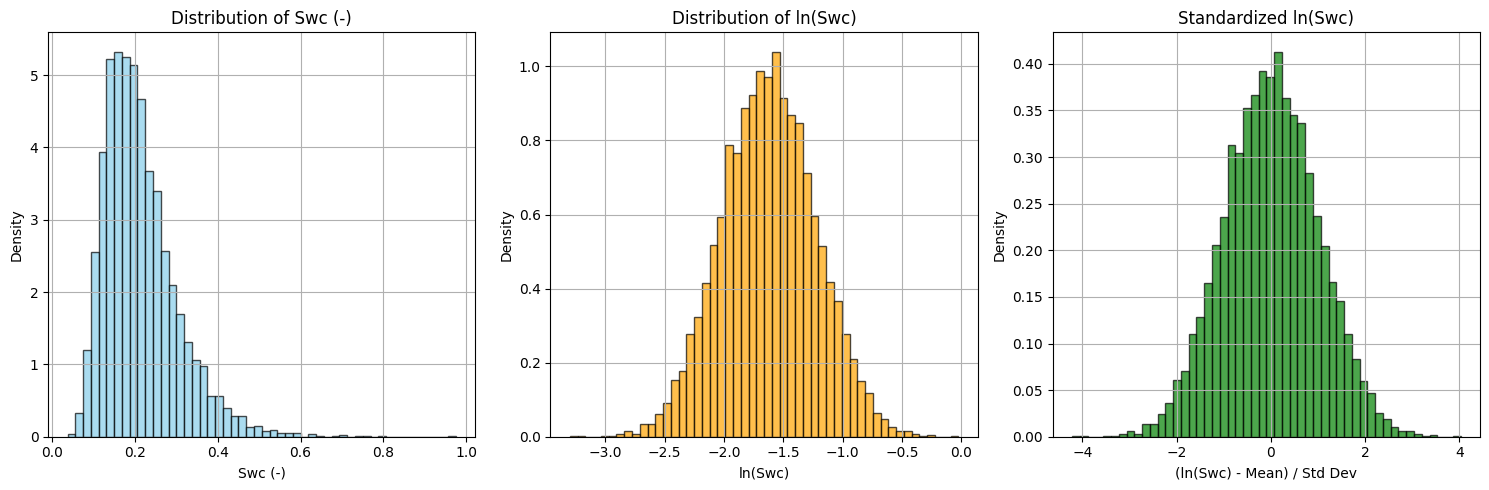

Mean of the log-normal distribution:               -1.624
Standard deviation of the log-normal distribution:  0.397
Mean of the Swc:                                    0.213
Standard deviation of Swc:                          0.088


In [13]:
mean_ln_swc, sd_ln_swc, z_scores_ln_swc, samples_ln_swc, samples_swc=swc()
# Plot histograms of Swc in fraction, ln(Swc), and standardized ln(Swc)
plt.figure(figsize=(15, 5))

# Plot histogram of Swc in fraction
plt.subplot(1, 3, 1)
plt.hist(samples_swc, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Swc (-)')
plt.xlabel('Swc (-)')
plt.ylabel('Density')
plt.grid(True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Plot histogram of ln(Swc)
plt.subplot(1, 3, 2)
plt.hist(samples_ln_swc, bins=50, density=True, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of ln(Swc)')
plt.xlabel('ln(Swc)')
plt.ylabel('Density')
plt.grid(True)

# Plot histogram of standardized ln(Swc)
plt.subplot(1, 3, 3)
plt.hist(z_scores_ln_swc, bins=50, density=True, color='green', edgecolor='black', alpha=0.7)
plt.title('Standardized ln(Swc)')
plt.xlabel('(ln(Swc) - Mean) / Std Dev')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()
  
print(f"Mean of the log-normal distribution:               {mean_ln_swc: .3f}\nStandard deviation of the log-normal distribution: {sd_ln_swc: .3f}")
print(f"Mean of the Swc:                                   {np.mean(samples_swc): .3f}\nStandard deviation of Swc:                         {np.std(samples_swc): .3f}")

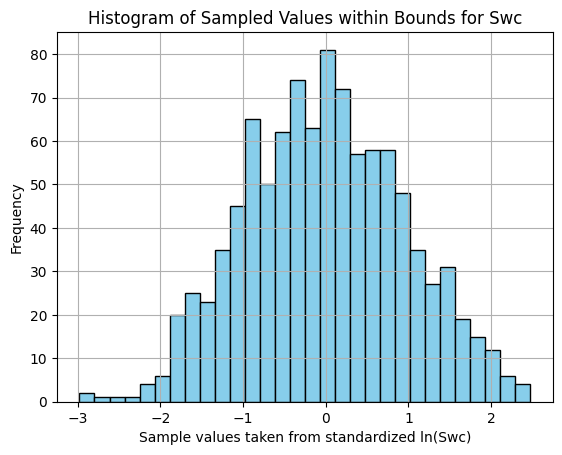

In [14]:
selected_swc=sample(z_scores=z_scores_ln_swc)

#Plot histogram of the samples to visualize their distribution
plt.hist(selected_swc, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sample values taken from standardized ln(Swc)')
plt.ylabel('Frequency')
plt.title('Histogram of Sampled Values within Bounds for Swc')
plt.grid(True)
plt.show()

Mean of Sample variables:              0.211
Standard Deviation of Sample variables:0.083
Sum of Absolute errore for Actual vs Modelled based on Samples is 0.00
Mean of modelled data:                 0.21
Standard deviation of modelled data:   0.08
Mean from A:                           0.21
std from A:                            0.09


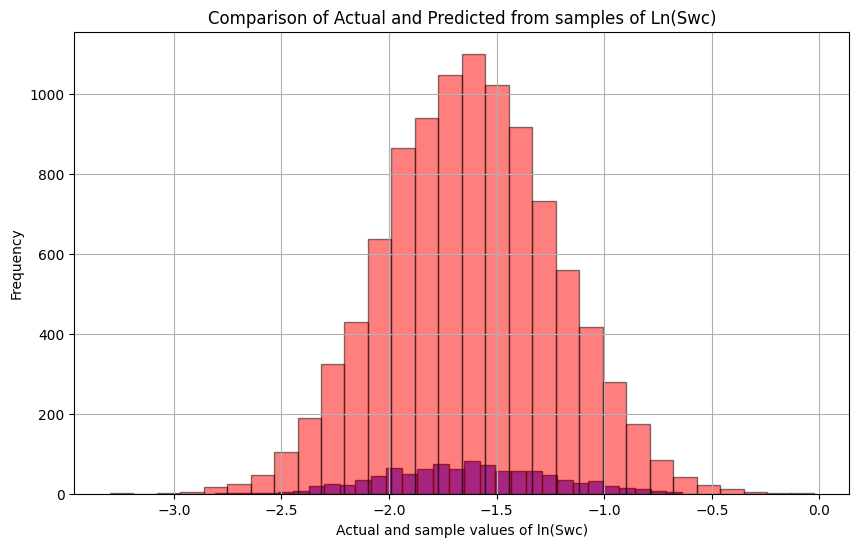

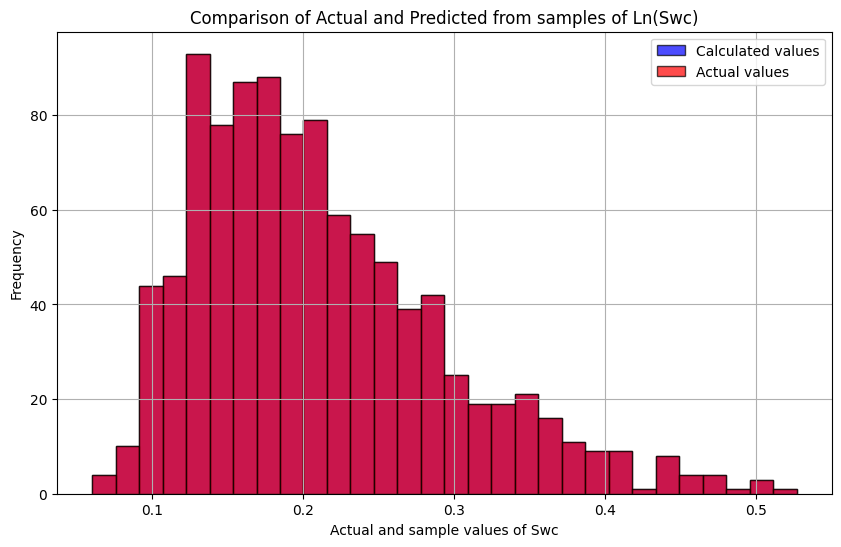

In [15]:
x_ln_swc, mean_sample_swc, sd_sample_swc, mean_model_swc, sd_model_swc, squared_err_swc, h_swc, swc, A_swc, mu_swc, var_swc=train(samples=selected_swc, sd_ln=sd_ln_swc, mean_ln=mean_ln_swc, samples_ln=samples_ln_swc)

print(f"Mean of Sample variables:              {mean_sample_swc:.3f}\nStandard Deviation of Sample variables:{sd_sample_swc:.3f}")
print(f"Sum of Absolute errore for Actual vs Modelled based on Samples is {squared_err_swc:.2f}")
print(f"Mean of modelled data:                 {mean_model_swc:.2f}\nStandard deviation of modelled data:   {sd_model_swc:.2f}")
print(f"Mean from A:                           {mu_swc:.2f}")
print(f"std from A:                            {np.sqrt(var_swc):.2f}")
  
plt.figure(figsize=(10, 6))
plt.hist(x_ln_swc, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.hist(samples_ln_swc, bins=30, color='red', edgecolor='black', alpha=0.5)
plt.xlabel('Actual and sample values of ln(Swc)')
plt.ylabel('Frequency')
plt.title('Comparison of Actual and Predicted from samples of Ln(Swc)')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(h_swc, bins=30, color='blue', edgecolor='black', alpha=0.7, label='Calculated values')
plt.hist(swc, bins=30, color='red', edgecolor='black', alpha=0.7, label='Actual values')
plt.xlabel('Actual and sample values of Swc')
plt.ylabel('Frequency')
plt.title('Comparison of Actual and Predicted from samples of Ln(Swc)')
plt.grid(True)
plt.legend(['Calculated values', 'Actual values'])
plt.show()

In [ ]:
SAE_swc_pop=[]
SAE_swc_sample=[]
degrees=range(4,8)

mus_swc=[]
vars_swc=[]

for i in degrees:
    _, _, _, _, _, squared_err_swc_sample, _, _, A_swc, mu_swc, var_swc =train(samples=selected_swc, sd_ln=sd_ln_swc, mean_ln=mean_ln_swc, samples_ln=samples_ln_swc, degree=i)
    SAE_swc_sample.append(squared_err_swc_sample)
    mus_swc.append(mu_swc)
    vars_swc.append(var_swc)
    
    X=hermite_polynomial(z_scores_ln_swc, i)
    h=np.dot(X, A_swc)
    err_swc=np.sum(np.square(h-samples_swc))
    SAE_swc_pop.append(err_swc)
    
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Degrees')
ax1.set_ylabel('Sample', color=color)
ax1.plot(degrees, SAE_swc_sample, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(range(min(degrees), max(degrees)+1))
# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Population', color=color)
ax2.plot(degrees, SAE_swc_pop, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Fixed value
mean_swc_ = np.mean(samples_swc)
sd_swc_=np.std(samples_swc)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, mus_swc, marker='o', linestyle='', label='Mean Values from A')
plt.axhline(y=mean_swc_, color='r', linestyle='--', label='Mean of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('Mean values from A\'s for each degree')
plt.title('Comparison of Mean of the population vs Mean from A coefficient')
plt.legend()
plt.xticks(ticks=np.arange(min(degrees), max(degrees)+1, 1))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, np.sqrt(vars_swc), marker='o', linestyle='', label='STD Values from A')
plt.axhline(y=sd_swc_, color='r', linestyle='--', label='STD of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('STD values from A\'s for each degree')
plt.title('Comparison of Mean of the population vs Mean from A coefficient')
plt.legend()

# Set the x-axis tick step to 1
plt.xticks(ticks=np.arange(min(degrees), max(degrees)+1, 1))
plt.grid(True)
plt.show()

In [ ]:
#Here we'll use the degree of 5 for NRV. sample_size will be 1500, 2500, 3500, 4500, 6000, 7500
population_size=10000
sample_sizes=np.dot(np.array([0.15, 0.25, 0.35, 0.45, 0.60, 0.75]), population_size)
SSE_swc_pop_ss=[]
SSE_swc_sample_ss=[]

mus_swc_ss=[]
vars_swc_ss=[]

#Sampling... In order to train our model we need samples... This function is for sampling for proper size
for i in sample_sizes:
    selected_swc_ss=sample(z_scores=z_scores_ln_swc, sample_size=i)
    _, _, _, _, _, squared_err_swc_sample_ss, _, _, A_swc_ss, mu_swc_ss, var_swc_ss =train(samples=selected_swc_ss, sd_ln=sd_ln_swc, mean_ln=mean_ln_swc, samples_ln=samples_ln_swc, degree=5)
    SSE_swc_sample_ss.append(squared_err_swc_sample_ss)
    mus_swc_ss.append(mu_swc_ss)
    vars_swc_ss.append(var_swc_ss)
    
    X=hermite_polynomial(z_scores_ln_swc, 5)
    h=np.dot(X, A_swc_ss)
    err_swc_ss=np.sum(np.square(h-samples_swc))
    SSE_swc_pop_ss.append(err_swc_ss)
    
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Sample_Sizes')
ax1.set_ylabel('Sample', color=color)
ax1.plot(sample_sizes, SSE_swc_sample_ss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Population', color=color)
ax2.plot(sample_sizes, SSE_swc_pop_ss, color=color)
ax2.tick_params(axis='y', labelcolor=color)



# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, mus_swc_ss, marker='o', linestyle='', label='Mean Values from A')
plt.axhline(y=mean_swc_, color='r', linestyle='--', label='Mean of Population')

# Add labels and title
plt.xlabel('Sample Size')
plt.ylabel('Mean values from A\'s for each sample size')
plt.title('Comparison of Mean of the population vs Mean from A coefficient for different sample Sizes')
plt.legend()

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, np.sqrt(vars_swc_ss), marker='o', linestyle='', label='STD Values from A')
plt.axhline(y=sd_swc_, color='r', linestyle='--', label='STD of Population')

# Add labels and title
plt.xlabel('Sample Sizes')
plt.ylabel('STD values from A\'s for each sample size')
plt.title('Comparison of Mean of the population vs Mean from A coefficient for different sample sizes')
plt.legend()


In [16]:
#Let's now populate our parameters:
# Parameters for the lognormal distribution
def sf(sf_min=0.95, sf_mode=1, sf_max=1.05, num_samples=10000):
    
    # Calculate mean and standard deviation of the lognormal distribution
    mean_sf=np.log(sf_mode**2 / np.sqrt(sf_min * sf_max))
    sigma_sf=np.sqrt(np.log(sf_max / sf_min) / (2.706 - np.log(sf_mode / np.sqrt(sf_min * sf_max))))
    
    # Generate samples from the lognormal distribution
    samples_sf = np.random.lognormal(mean=mean_sf, sigma=sigma_sf, size=num_samples)

    # Take the natural logarithm of the samples to get samples of ln(NRV)
    samples_ln_sf = np.log(samples_sf)

    # Standardize ln(SFoi) samples to obtain z-scores
    mean_ln_sf=np.mean(samples_ln_sf)
    sd_ln_sf=np.std(samples_ln_sf)
    z_scores_ln_sf = (samples_ln_sf - mean_ln_sf)/sd_ln_sf

    return mean_ln_sf, sd_ln_sf, z_scores_ln_sf, samples_ln_sf, samples_sf

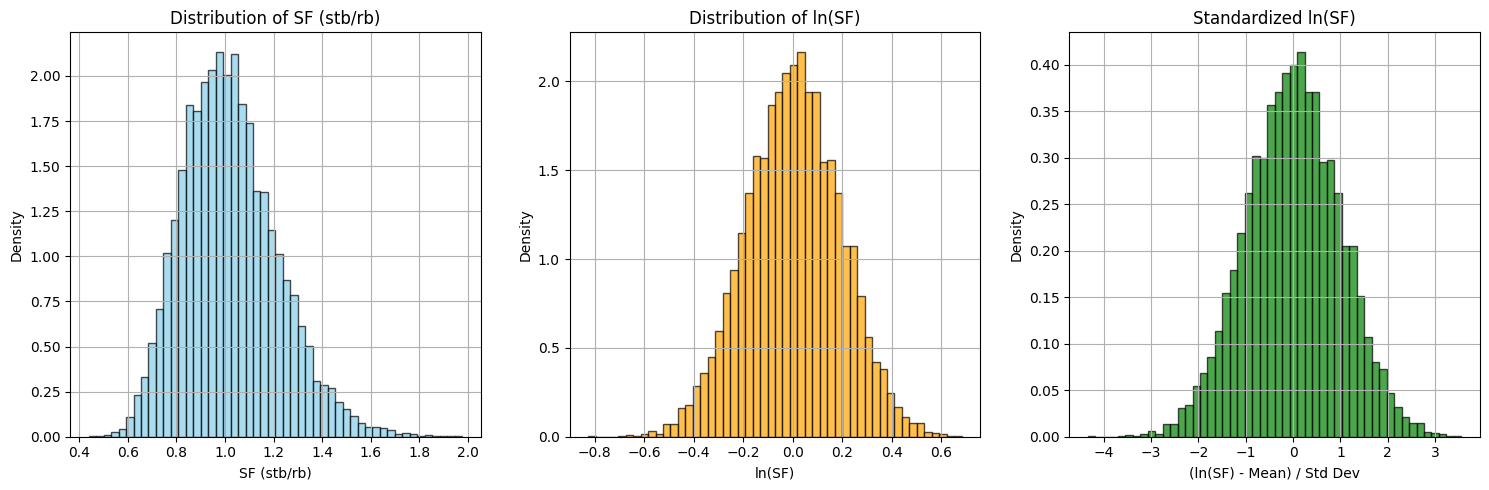

Mean of the log-normal distribution:                0.003
Standard deviation of the log-normal distribution:  0.191
Mean of the SF:                                     1.021
Standard deviation of SF:                           0.196


In [17]:
mean_ln_sf, sd_ln_sf, z_scores_ln_sf, samples_ln_sf, samples_sf=sf()
# Plot histograms of SF in stb/rb, ln(SF), and standardized ln(SF)
plt.figure(figsize=(15, 5))

# Plot histogram of SF in stb/rb
plt.subplot(1, 3, 1)
plt.hist(samples_sf, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of SF (stb/rb)')
plt.xlabel('SF (stb/rb)')
plt.ylabel('Density')
plt.grid(True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Plot histogram of ln(SF)
plt.subplot(1, 3, 2)
plt.hist(samples_ln_sf, bins=50, density=True, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of ln(SF)')
plt.xlabel('ln(SF)')
plt.ylabel('Density')
plt.grid(True)

# Plot histogram of standardized ln(SF)
plt.subplot(1, 3, 3)
plt.hist(z_scores_ln_sf, bins=50, density=True, color='green', edgecolor='black', alpha=0.7)
plt.title('Standardized ln(SF)')
plt.xlabel('(ln(SF) - Mean) / Std Dev')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()
  
print(f"Mean of the log-normal distribution:               {mean_ln_sf: .3f}\nStandard deviation of the log-normal distribution: {sd_ln_sf: .3f}")
print(f"Mean of the SF:                                    {np.mean(samples_sf): .3f}\nStandard deviation of SF:                          {np.std(samples_sf): .3f}")

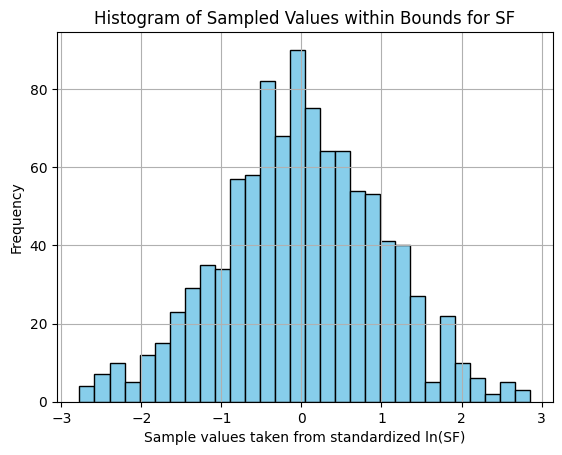

In [18]:
selected_sf=sample(z_scores=z_scores_ln_sf)

#Plot histogram of the samples to visualize their distribution
plt.hist(selected_sf, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sample values taken from standardized ln(SF)')
plt.ylabel('Frequency')
plt.title('Histogram of Sampled Values within Bounds for SF')
plt.grid(True)
plt.show()

Mean of Sample variables:              1.019
Standard Deviation of Sample variables:0.195
Sum of Absolute errore for Actual vs Modelled based on Samples is 0.00e-09
Mean of modelled data:                 1.02
Standard deviation of modelled data:   0.19
Mean from A:                           1.02
std from A:                            0.20


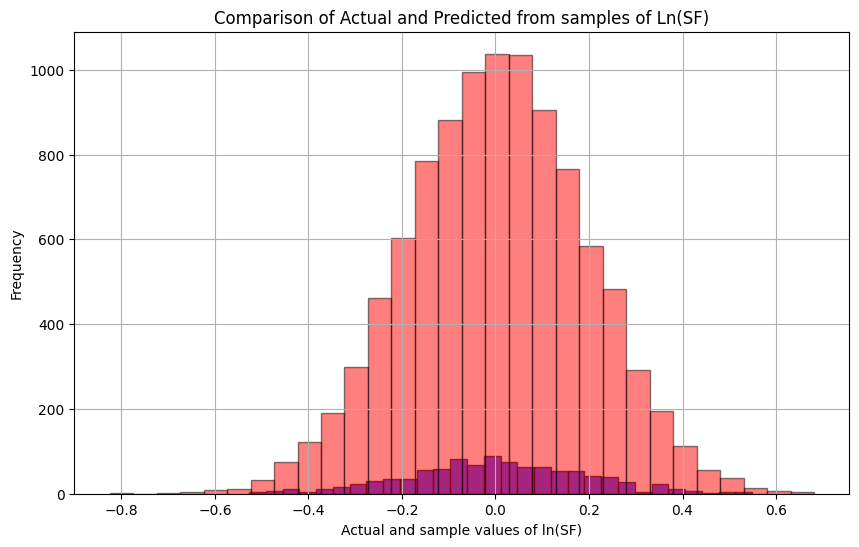

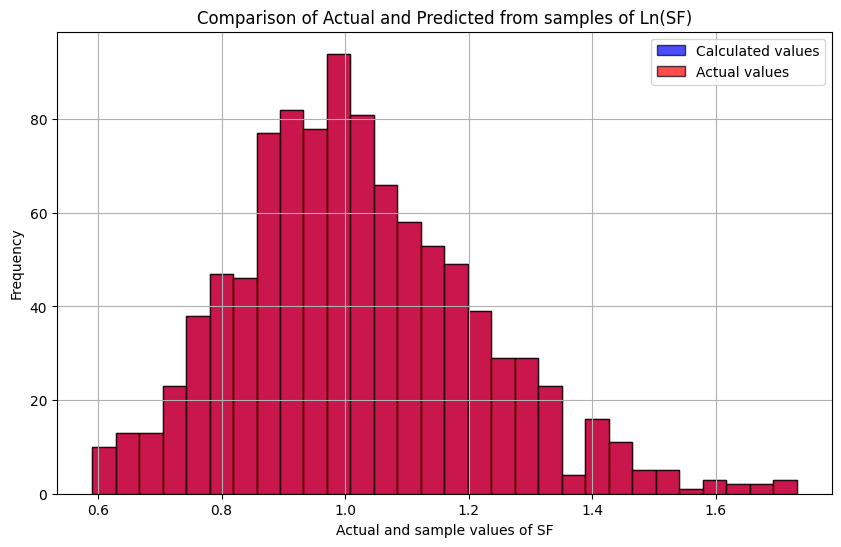

In [19]:
x_ln_sf, mean_sample_sf, sd_sample_sf, mean_model_sf, sd_model_sf, squared_err_sf, h_sf, sf, A_sf, mu_sf, var_sf=train(samples=selected_sf, sd_ln=sd_ln_sf, mean_ln=mean_ln_sf, samples_ln=samples_ln_sf)

print(f"Mean of Sample variables:              {mean_sample_sf:.3f}\nStandard Deviation of Sample variables:{sd_sample_sf:.3f}")
print(f"Sum of Absolute errore for Actual vs Modelled based on Samples is {10**9*squared_err_sf:.2f}e-09")
print(f"Mean of modelled data:                 {mean_model_sf:.2f}\nStandard deviation of modelled data:   {sd_model_sf:.2f}")
print(f"Mean from A:                           {mu_sf:.2f}")
print(f"std from A:                            {np.sqrt(var_sf):.2f}")
  
plt.figure(figsize=(10, 6))
plt.hist(x_ln_sf, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.hist(samples_ln_sf, bins=30, color='red', edgecolor='black', alpha=0.5)
plt.xlabel('Actual and sample values of ln(SF)')
plt.ylabel('Frequency')
plt.title('Comparison of Actual and Predicted from samples of Ln(SF)')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(h_sf, bins=30, color='blue', edgecolor='black', alpha=0.7, label='Calculated values')
plt.hist(sf, bins=30, color='red', edgecolor='black', alpha=0.7, label='Actual values')
plt.xlabel('Actual and sample values of SF')
plt.ylabel('Frequency')
plt.title('Comparison of Actual and Predicted from samples of Ln(SF)')
plt.grid(True)
plt.legend(['Calculated values', 'Actual values'])
plt.show()

In [ ]:
# for each degree let's calculate SSE based on population data
SAE_sf_sample=[]
SAE_sf_pop=[]
degrees=range(4,8)
mus_sf=[]
vars_sf=[]

for i in degrees:
    _, _, _, _, _, squared_err_sf_sample, _, _, A_sf, mu_sf, var_sf =train(samples=selected_sf, sd_ln=sd_ln_sf, mean_ln=mean_ln_sf, samples_ln=samples_ln_sf, degree=i)
    SAE_sf_sample.append(squared_err_sf_sample)
    mus_sf.append(mu_sf)
    vars_sf.append(var_sf)
    
    X=hermite_polynomial(z_scores_ln_sf,i)
    h=np.dot(X, A_sf)
    err_sf=np.sum(np.square(h-samples_sf))
    SAE_sf_pop.append(err_sf)
    
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Degrees')
ax1.set_ylabel('Sample', color=color)
ax1.plot(degrees, SAE_sf_sample, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(range(min(degrees), max(degrees)+1))

# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Population', color=color)
ax2.plot(degrees, SAE_sf_pop, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# Fixed value
mean_sf_ = np.mean(samples_sf)
sd_sf_=np.std(samples_sf)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, mus_sf, marker='o', linestyle='', label='Mean Values from A')
plt.axhline(y=mean_sf_, color='r', linestyle='--', label='Mean of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('Mean values from A\'s for each degree')
plt.title('Comparison of Mean of the population vs Mean from A coefficient')
plt.legend()
plt.xticks(ticks=np.arange(min(degrees), max(degrees)+1, 1))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, np.sqrt(vars_sf), marker='o', linestyle='', label='STD Values from A')
plt.axhline(y=sd_sf_, color='r', linestyle='--', label='STD of Population')

# Add labels and title
plt.xlabel('Degrees of Polynomial')
plt.ylabel('STD values from A\'s for each degree')
plt.title('Comparison of Mean of the population vs Mean from A coefficient')
plt.legend()

# Set the x-axis tick step to 1
plt.xticks(ticks=np.arange(min(degrees), max(degrees)+1, 1))
plt.grid(True)
plt.show()

In [ ]:
#Here we'll use the degree of 5 for NRV. sample_size will be 1500, 2500, 3500, 4500, 6000, 7500
population_size=10000
sample_sizes=np.dot(np.array([0.15, 0.25, 0.35, 0.45, 0.60, 0.75]), population_size)
SSE_sf_pop_ss=[]
SSE_sf_sample_ss=[]
mus_sf_ss=[]
vars_sf_ss=[]

#Sampling... In order to train our model we need samples... This function is for sampling for proper size
for i in sample_sizes:
    selected_sf_ss=sample(z_scores=z_scores_ln_sf, sample_size=i)
    _, _, _, _, _, squared_err_sf_sample_ss, _, _, A_sf_ss, mu_sf_ss, var_sf_ss =train(samples=selected_sf_ss, sd_ln=sd_ln_sf, mean_ln=mean_ln_sf, samples_ln=samples_ln_sf, degree=5)
    SSE_sf_sample_ss.append(squared_err_sf_sample_ss)
    mus_sf_ss.append(mu_sf_ss)
    vars_sf_ss.append(var_sf_ss)
    
    X=hermite_polynomial(z_scores_ln_sf,5)
    h=np.dot(X, A_sf_ss)
    err_sf_ss=np.sum(np.square(h-samples_sf))
    SSE_sf_pop_ss.append(err_sf_ss)
    
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset with the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Sample_Sizes')
ax1.set_ylabel('Sample', color=color)
ax1.plot(sample_sizes, SSE_sf_sample_ss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Population', color=color)
ax2.plot(sample_sizes, SSE_sf_pop_ss, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, mus_sf_ss, marker='o', linestyle='', label='Mean Values from A')
plt.axhline(y=mean_sf_, color='r', linestyle='--', label='Mean of Population')

# Add labels and title
plt.xlabel('Sample Size')
plt.ylabel('Mean values from A\'s for each sample size')
plt.title('Comparison of Mean of the population vs Mean from A coefficient for different sample Sizes')
plt.legend()

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, np.sqrt(vars_sf_ss), marker='o', linestyle='', label='STD Values from A')
plt.axhline(y=sd_sf_, color='r', linestyle='--', label='STD of Population')

# Add labels and title
plt.xlabel('Sample Sizes')
plt.ylabel('STD values from A\'s for each sample size')
plt.title('Comparison of Mean of the population vs Mean from A coefficient for different sample sizes')
plt.legend()

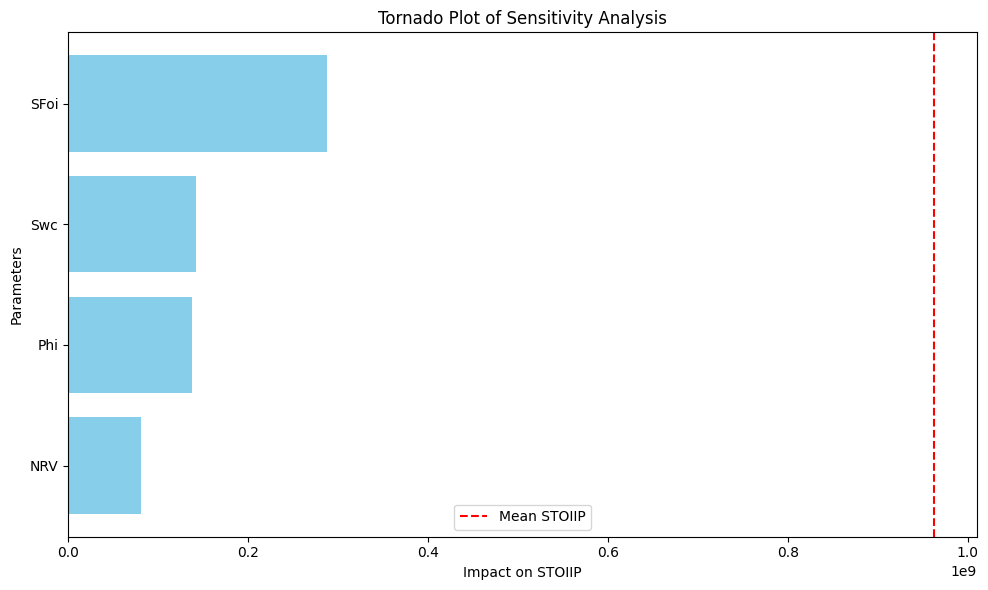

In [20]:
# Parameters for sensitivity analysis
num_samples = 10000  # Number of samples for each parameter
num_params = 4  # Number of parameters (GRV, Phi, Swc, SFoi)

# Mean and standard deviation of ln-transformed parameters
means = [mean_ln_nrv, mean_ln_phi, mean_ln_swc, mean_ln_sf]
sds = [sd_ln_nrv, sd_ln_phi, sd_ln_swc, sd_ln_sf]

# Initialize arrays to store sensitivity results
param_values = np.zeros((num_samples, num_params))  # Array to store sampled parameter values
stoiip_results = np.zeros(num_samples)  # Array to store STOIIP results

# Perform sensitivity analysis
for i in range(num_samples):
    # Generate random samples for each parameter
    samples = [np.random.normal(means[j], sds[j]) for j in range(num_params)]
    
    # Calculate STOIIP for the current set of samples
    stoiip = 7758 * np.exp(samples[0]) * np.exp(samples[1]) * (1 - np.exp(samples[2])) * np.exp(samples[3])
    
    # Store parameter values and STOIIP result
    param_values[i] = samples
    stoiip_results[i] = stoiip

# Calculate mean STOIIP for each parameter
mean_stoiip = np.mean(stoiip_results)

# Calculate the impact of each parameter on STOIIP
param_impact = [np.abs(np.mean(stoiip_results) - np.mean(stoiip_results[param_values[:, i] < means[i]])) for i in range(num_params)]

# Sort parameters and impacts
sorted_indices = np.argsort(param_impact)
sorted_params = ['NRV', 'Phi', 'Swc', 'SFoi']
sorted_impact = [param_impact[i] for i in sorted_indices]

# Create tornado plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars
ax.barh(sorted_params, sorted_impact, color='skyblue')
ax.axvline(x=mean_stoiip, color='red', linestyle='--', label='Mean STOIIP')

# Add labels and title
ax.set_xlabel('Impact on STOIIP')
ax.set_ylabel('Parameters')
ax.set_title('Tornado Plot of Sensitivity Analysis')
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
def stoiip(grv=nrv, phi=phi, swc=swc, sf=sf):
    STOIIP = 7758 * grv * phi * (1 - swc) * sf
    plt.figure(figsize=(10, 6))
    plt.hist(STOIIP, bins=150, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.title('Histogram of STOIIP')
    plt.xlabel('STOIIP, e03 MM STB')
    plt.ylabel('Density')

    plt.grid(True)
    plt.show()
    
    mean_STOIIP = np.mean(STOIIP)
    std_dev_STOIIP = np.std(STOIIP)

    print(f"Mean of STOIIP:              {mean_STOIIP:.3f}")
    print(f"Standard Deviation of STOIIP:{std_dev_STOIIP:.3f}")
    
    # Calculate percentiles
    P10 = np.percentile(STOIIP, 10)
    P50 = np.percentile(STOIIP, 50)  # Median
    P90 = np.percentile(STOIIP, 90)

    # Create CDF plot
    plt.figure(figsize=(10, 6))
    plt.hist(STOIIP, bins=150, density=True, cumulative=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(P10, color='r', linestyle='--')
    plt.axvline(P50, color='g', linestyle='--')
    plt.axvline(P90, color='b', linestyle='--')

    # Add labels and title
    plt.title('Cumulative Distribution Function (CDF) of STOIIP')
    plt.xlabel('STOIIP')
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.show()

    # Print the P10, P50, and P90 values
    print(f"P90 =      {P10:.2f}")
    print(f"P50 =      {P50:.2f}")
    print(f"P10 =     {P90:.2f}")
    
    return mean_STOIIP, std_dev_STOIIP, P10, P50, P90

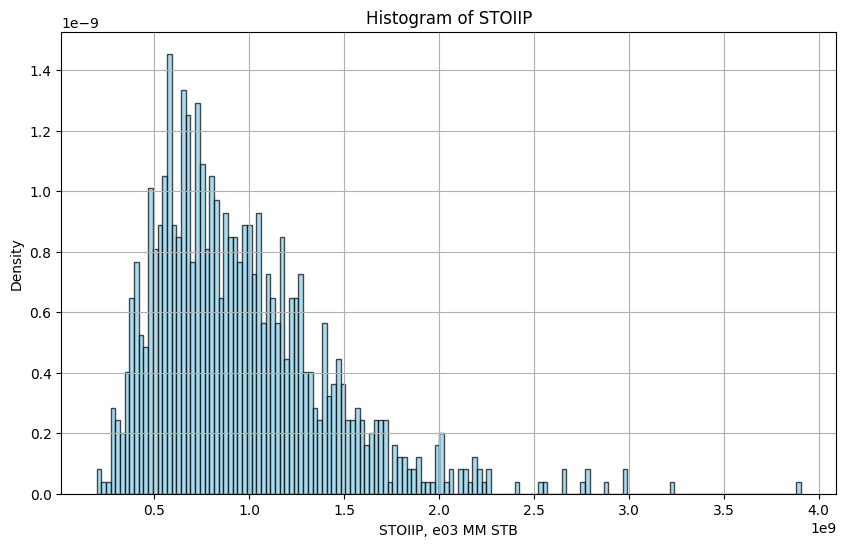

Mean of STOIIP:              961165755.536
Standard Deviation of STOIIP:464648497.304


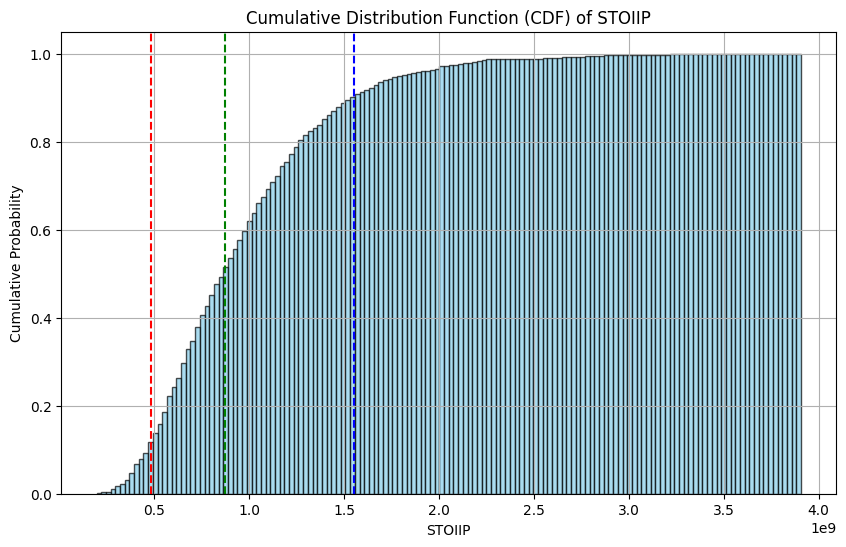

P90 =      481199187.65
P50 =      873994120.42
P10 =     1553178506.75


In [22]:
mu, sd, p10, p50, p90=stoiip()

In [23]:
def stoiip_model(grv=h_nrv, phi=h_phi, swc=h_swc, sf=h_sf):
    STOIIP = 7758 * grv * phi * (1-swc) * sf
    plt.figure(figsize=(10, 6))
    plt.hist(STOIIP, bins=150, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.title('Histogram of STOIIP')
    plt.xlabel('STOIIP, e03 MM STB')
    plt.ylabel('Density')

    plt.grid(True)
    plt.show()
    
    mean_STOIIP = np.mean(STOIIP)
    std_dev_STOIIP = np.std(STOIIP)

    print(f"Mean of STOIIP:              {mean_STOIIP:.3f}")
    print(f"Standard Deviation of STOIIP:{std_dev_STOIIP:.3f}")
    
    # Calculate percentiles
    P10 = np.percentile(STOIIP, 10)
    P50 = np.percentile(STOIIP, 50)  # Median
    P90 = np.percentile(STOIIP, 90)

    # Create CDF plot
    plt.figure(figsize=(10, 6))
    plt.hist(STOIIP, bins=150, density=True, cumulative=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(P10, color='r', linestyle='--')
    plt.axvline(P50, color='g', linestyle='--')
    plt.axvline(P90, color='b', linestyle='--')

    # Add labels and title
    plt.title('Cumulative Distribution Function (CDF) of STOIIP')
    plt.xlabel('STOIIP')
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.show()

    # Print the P10, P50, and P90 values
    print(f"P90 =      {P10:.2f}")
    print(f"P50 =      {P50:.2f}")
    print(f"P10 =     {P90:.2f}")
    
    return mean_STOIIP, std_dev_STOIIP, P10, P50, P90

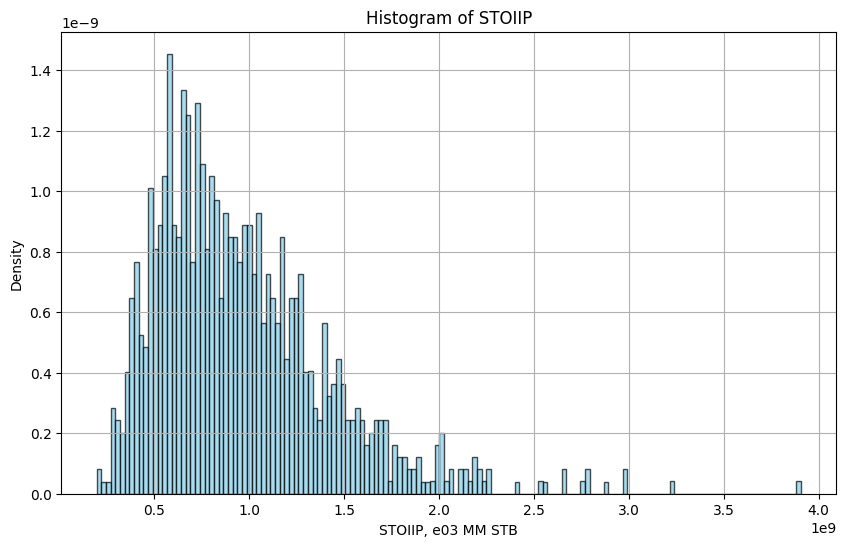

Mean of STOIIP:              961165747.164
Standard Deviation of STOIIP:464648259.698


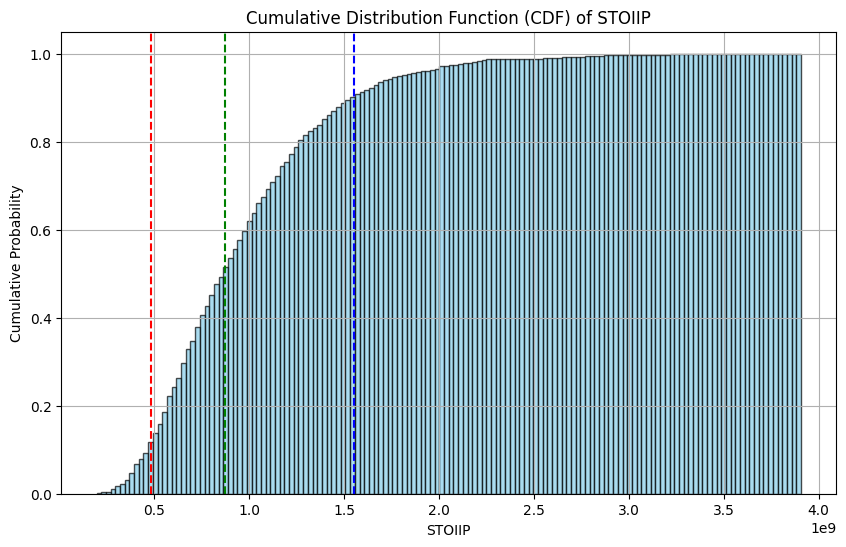

P90 =      481197950.28
P50 =      873996545.32
P10 =     1553177549.37


In [24]:
mu_h, sd_h, p10_h, p50_h, p90_h = stoiip_model()